# Loading Dependencies

In [ ]:
!pip install inference

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.9/891.9 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install -q git+https://github.com/roboflow/sports.git

  Preparing metadata (setup.py) ... done


In [ ]:
!pip uninstall -y supervision && pip install -q supervision>=0.23.0

Found existing installation: supervision 0.25.1
Uninstalling supervision-0.25.1:
  Successfully uninstalled supervision-0.25.1


# Loading Player Detection Model from Yolo

In [ ]:
from inference import get_model
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/12"
PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

ModelDependencyMissing: Your `inference` configuration does not support Qwen2.5-VL model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[clip]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support Gaze Detection model. Use pip install 'inference[gaze]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support GroundingDINO model. Use pip install 'inference[grounding-dino]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration d

# Team Classifying

In [ ]:
from tqdm import tqdm
import supervision as sv
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/Ai League/video.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

collecting crops: 25it [08:27, 20.32s/it]


In [ ]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

In [ ]:
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)

embedding extraction: 16it [06:22, 23.92s/it]


In [ ]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [ ]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "/content/drive/MyDrive/Ai League/video.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cpu")
team_classifier.fit(crops)

collecting crops: 25it [08:14, 19.77s/it]
Embedding extraction: 19it [07:47, 24.58s/it]


# Goalkeeper Detection

In [ ]:
import numpy as np
import supervision as sv

def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

# Load Key points Detection for Pitch from Yolo

In [ ]:
from inference import get_model
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi/15"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

In [ ]:
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

In [ ]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "/content/drive/MyDrive/Ai League/video.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cpu")
team_classifier.fit(crops)

collecting crops: 25it [08:14, 19.79s/it]
Embedding extraction: 19it [07:28, 23.62s/it]


# Check the Frame

Embedding extraction: 1it [00:13, 13.69s/it]


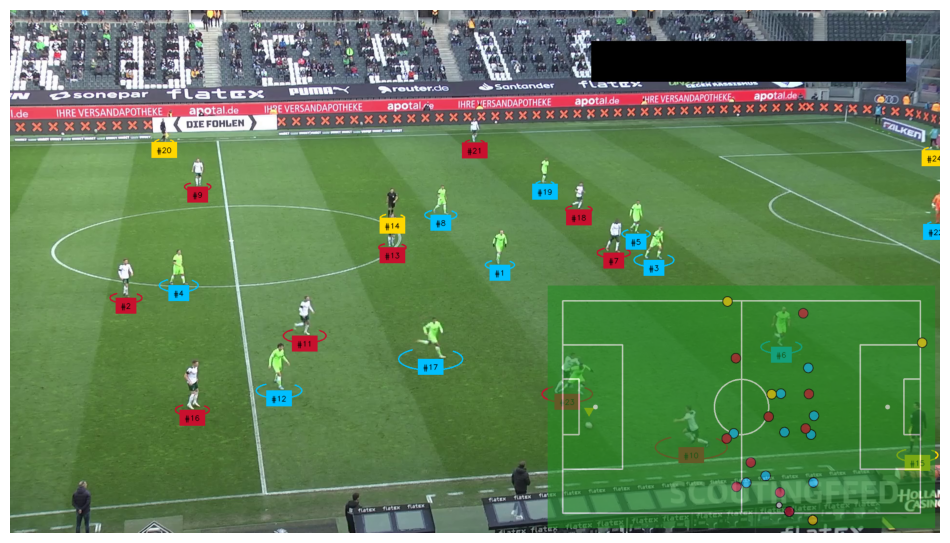

In [ ]:
import supervision as sv
import cv2
import numpy as np
from sports.common.view import ViewTransformer
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch
)



# Set up video path and IDs
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/Ai League/video.mp4"
BALL_ID, GOALKEEPER_ID, PLAYER_ID, REFEREE_ID = 0, 1, 2, 3

# Annotators for drawing detections
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF','#C8102E','#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF','#C8102E','#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

# Object Tracker
tracker = sv.ByteTrack()
tracker.reset()

# Read frame
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# Object Detection
result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

# Filter detections
ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID].with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

players_detections = all_detections[all_detections.class_id == PLAYER_ID]
goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

# Assign team classifications
players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)
referees_detections.class_id -= 1  # Adjust referee class ID

all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])

# Ensure class_id is of integer type before annotation
all_detections.class_id = all_detections.class_id.astype(int)

# Annotate frame
labels = [f"#{tracker_id}" for tracker_id in all_detections.tracker_id]
annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
annotated_frame = label_annotator.annotate(annotated_frame, all_detections, labels=labels)
annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)

# Field Key Points Detection
result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

# Perspective Transformation
filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(source=frame_reference_points, target=pitch_reference_points)

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = transformer.transform_points(points=players_xy)

referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referees_xy = transformer.transform_points(points=referees_xy)

# Draw Radar View
radar_frame = draw_pitch(CONFIG)
radar_frame = draw_points_on_pitch(CONFIG, pitch_ball_xy, face_color=sv.Color.WHITE, edge_color=sv.Color.BLACK, radius=10, pitch=radar_frame)
radar_frame = draw_points_on_pitch(CONFIG, pitch_players_xy[players_detections.class_id == 0], face_color=sv.Color.from_hex('#00BFFF'), edge_color=sv.Color.BLACK, radius=16, pitch=radar_frame)
radar_frame = draw_points_on_pitch(CONFIG, pitch_players_xy[players_detections.class_id == 1], face_color=sv.Color.from_hex('#C8102E'), edge_color=sv.Color.BLACK, radius=16, pitch=radar_frame)
radar_frame = draw_points_on_pitch(CONFIG, pitch_referees_xy, face_color=sv.Color.from_hex('FFD700'), edge_color=sv.Color.BLACK, radius=16, pitch=radar_frame)

# Resize radar
radar_resized = cv2.resize(radar_frame, (800, 500))

# Place radar in bottom-right corner
h, w, _ = annotated_frame.shape
x_offset = w - 810
y_offset = h - 510

# Convert radar to BGR if needed
if radar_resized.shape[2] == 4:
    radar_resized = cv2.cvtColor(radar_resized, cv2.COLOR_RGBA2RGB)

# Blend radar with opacity
alpha = 0.6
overlay = annotated_frame.copy()
overlay[y_offset:y_offset + 500, x_offset:x_offset + 800] = radar_resized
cv2.addWeighted(overlay, alpha, annotated_frame, 1 - alpha, 0, annotated_frame)

# Show final frame
sv.plot_image(annotated_frame)

# Final Video Output

In [ ]:
from tqdm import tqdm
import supervision as sv
import cv2
import numpy as np
from sports.common.view import ViewTransformer
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch
)

# Set up video path and IDs
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/Ai League/video.mp4"
TARGET_VIDEO_PATH = "/content/drive/MyDrive/Ai League/Result_final.mp4"

BALL_ID, GOALKEEPER_ID, PLAYER_ID, REFEREE_ID = 0, 1, 2, 3

# Annotators for drawing detections
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF','#C8102E','#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF','#C8102E','#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

# Object Tracker
tracker = sv.ByteTrack()
tracker.reset()

# Read frame
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        # Object Detection
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        # Filter detections
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID].with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(detections=all_detections)

        # Ensure `tracker_id` and `class_id` are valid
        if all_detections.tracker_id is not None:
            valid_indices = ~np.isnan(all_detections.tracker_id)  # Remove NaN tracker IDs
            all_detections = all_detections[valid_indices]
            all_detections.tracker_id = all_detections.tracker_id.astype(int)

        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        # Assign team classifications
        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)

        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)
        referees_detections.class_id -= 1  # Adjust referee class ID

        # Ensure `class_id` is integer
        all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])
        all_detections.class_id = all_detections.class_id.astype(int)

        # Annotate frame
        labels = [f"#{int(tracker_id)}" for tracker_id in all_detections.tracker_id]  # Convert IDs to int
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
        annotated_frame = label_annotator.annotate(annotated_frame, all_detections, labels=labels)
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)

        # Field Key Points Detection
        result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        key_points = sv.KeyPoints.from_inference(result)

        # Perspective Transformation
        filter = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter]
        pitch_reference_points = np.array(CONFIG.vertices)[filter]

        transformer = ViewTransformer(source=frame_reference_points, target=pitch_reference_points)

        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

        players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_players_xy = transformer.transform_points(points=players_xy)

        referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_referees_xy = transformer.transform_points(points=referees_xy)

        # Draw Radar View
        radar_frame = draw_pitch(CONFIG)
        radar_frame = draw_points_on_pitch(CONFIG, pitch_ball_xy, face_color=sv.Color.WHITE, edge_color=sv.Color.BLACK, radius=10, pitch=radar_frame)
        radar_frame = draw_points_on_pitch(CONFIG, pitch_players_xy[players_detections.class_id == 0], face_color=sv.Color.from_hex('#00BFFF'), edge_color=sv.Color.BLACK, radius=16, pitch=radar_frame)
        radar_frame = draw_points_on_pitch(CONFIG, pitch_players_xy[players_detections.class_id == 1], face_color=sv.Color.from_hex('#C8102E'), edge_color=sv.Color.BLACK, radius=16, pitch=radar_frame)
        radar_frame = draw_points_on_pitch(CONFIG, pitch_referees_xy, face_color=sv.Color.from_hex('FFD700'), edge_color=sv.Color.BLACK, radius=16, pitch=radar_frame)

        # Resize radar
        radar_resized = cv2.resize(radar_frame, (800, 500))

        # Place radar in bottom-right corner
        h, w, _ = annotated_frame.shape
        x_offset = w - 810
        y_offset = h - 510

        # Convert radar to BGR if needed
        if radar_resized.shape[2] == 4:
            radar_resized = cv2.cvtColor(radar_resized, cv2.COLOR_RGBA2RGB)

        # Blend radar with opacity
        alpha = 0.6
        overlay = annotated_frame.copy()
        overlay[y_offset:y_offset + 500, x_offset:x_offset + 800] = radar_resized
        cv2.addWeighted(overlay, alpha, annotated_frame, 1 - alpha, 0, annotated_frame)

        # Write frame to video
        video_sink.write_frame(annotated_frame)


  0%|          | 0/750 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:13, 13.74s/it]
  0%|          | 1/750 [00:38<8:02:08, 38.62s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:13, 13.61s/it]
  0%|          | 2/750 [01:16<7:53:32, 37.98s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:13, 13.17s/it]
  0%|          | 3/750 [01:54<7:53:57, 38.07s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:13, 13.58s/it]
  1%|          | 4/750 [02:33<7:57:00, 38.37s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:13, 13.62s/it]
  1%|          | 5/750 [03:09<7:47:57, 37.69s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:12, 12.22s/it]
  1%|          | 6/750 [03:46<7:45:51, 37.57s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:13, 13.66s/it]
  1%|          | 7/750 [04:24<7:45:49, 37.62s/it]
Embeddin